In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

from scipy.stats import jarque_bera
from sklearn.metrics import r2_score
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

lags=60

In [7]:
def calculate_metrics_sample(y):
    sample = pd.Series(y)
    
    y_dict = {}

    y_dict['series'] = 'Y'
    y_dict['observations'] = sample.size
    y_dict['mode'] = sample.mode()[0]
    y_dict['mean'] = sample.mean()
    y_dict['median'] = sample.median()
    y_dict['variation'] = sample.var()
    y_dict['skewness'] = sample.skew()
    y_dict['kurtosis'] = sample.kurt()
    y_dict['jarque-bera'] = jarque_bera(sample).statistic
    y_dict['probability'] = jarque_bera(sample).pvalue
    
    return y_dict

In [12]:
def claculate_metrics_model(y, y_pred, p, q=0, weight='none', window=0, params_ar='empty', params_ma='empty', intercept='empty'):
    
    if len(y) == len(y_pred):
        y , y_pred = np.array(y), np.array(y_pred)
        print('True')
    else:
        y , y_pred = np.array(y[len(y)-len(y_pred):] - np.array(y_pred)), np.array(y_pred)
        print('False')
    
#     print(f'pred:\t{y_pred}')
#     print(f'y:\t{y}')
    model_params = p + q
    model_arma_metric = {}
    model_arma_metric['name'] = f'ARMA({p,q}) {weight}:{window}'
    model_arma_metric['r_squared'] = r2_score(y, y_pred) #1 - (np.var(y_pred)/np.var(y))**2
    model_arma_metric['sum_squared_resid'] = np.sum((y - y_pred)**2)
    model_arma_metric['aic'] = len(y) * np.log(model_arma_metric['sum_squared_resid'] / len(y)) + 2*model_params
    model_arma_metric['durbin_watson'] = durbin_watson(y - y_pred)
    model_arma_metric['params_ar'] = params_ar
    model_arma_metric['params_ma'] = params_ma
    model_arma_metric['params_intercept'] = intercept
    
    return pd.DataFrame(np.array([[metr] for metr in model_arma_metric.values()]).T, 
                        columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])

In [13]:
def claculate_metrics_trend(y, y_pred,trend=1, params_ar='empty', intercept='empty'):
    
    if len(y) == len(y_pred):
        y , y_pred = np.array(y), np.array(y_pred)
        print('True')
    else:
        y , y_pred = np.array(y[len(y)-len(y_pred):] - np.array(y_pred)), np.array(y_pred)
        print('False')
    
#     print(f'pred:\t{y_pred}')
#     print(f'y:\t{y}')
    model_arma_metric = {}
    model_arma_metric['name'] = f'Trend({trend})'
    model_arma_metric['r_squared'] = r2_score(y, y_pred) #1 - (np.var(y_pred)/np.var(y))**2
    model_arma_metric['sum_squared_resid'] = np.sum((y - y_pred)**2)
    model_arma_metric['durbin_watson'] = durbin_watson(y - y_pred)
    model_arma_metric['params_ar'] = params_ar
    model_arma_metric['params_intercept'] = intercept
    
    return pd.DataFrame(np.array([[metr] for metr in model_arma_metric.values()]).T, 
                        columns=['name', 'r_squared', 'sum_squared_resid','durbin_watson','params_ar','params_intercept'])

In [50]:
def claculate_metrics_Real(y, y_pred, name, p=0,q=0):
    
    y , y_pred = np.array(y), np.array(y_pred)

    
#     print(f'pred:\t{y_pred}')
#     print(f'y:\t{y}')
    model_arma_metric = {}
    model_arma_metric['name'] = f'{name}{p,q}'
    model_arma_metric['r_squared'] = r2_score(y, y_pred) #1 - (np.var(y_pred)/np.var(y))**2
    model_arma_metric['sum_squared_resid'] = np.sum((y - y_pred)**2)
    model_arma_metric['durbin_watson'] = durbin_watson(y - y_pred)
#     model_arma_metric['params_ar'] = params_ar
#     model_arma_metric['params_intercept'] = intercept
    
    return pd.DataFrame(np.array([[metr] for metr in model_arma_metric.values()]).T, 
                        columns=['name', 'r_squared', 'sum_squared_resid','durbin_watson'])#,'params_ar','params_intercept'])

In [14]:
def weight(res, weight, window):
    
    res_copy = res.copy()
    if weight=='simple':
        wma = res_copy.rolling(window=window).mean()
        
        
    elif weight== 'exponential':
        wma = res_copy.ewm(span=window).mean()
    
    else:
        pass
    
    wma[:window] = res_copy[:window]
    return wma

In [15]:
def show_prediction(y, y_pred, name='', pred_title='pred'):
    plt.figure(figsize= (15,6.5))
    plt.title(name)
    plt.plot([x for x in range(len(y))],y, label='y')
    plt.plot([x for x in range(len(y) - len(y_pred), len(y))],y_pred, label=pred_title)
    plt.legend()
    plt.show()
    

In [11]:
def show_plots(y):
    sample = pd.Series(y)
    plt.figure(figsize=(10,6))
    plt.title('Sample')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.plot(sample)
    plt.grid(True)
    plt.show()
    
    plot_pacf(sample, lags=lags);
    plot_acf(sample, lags=lags);

In [9]:
def adf_check(time_series):
    """
    Pass in a time series, return ADF report
    """
    
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test')
    
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print(f"strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary {result[1]}")
    else:
        print(f"weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary {result[1]}\n")

Reading file

In [18]:
file1 = open('ATS_Lab_04_new/data/RSAFSNA.txt')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])
(len(y))

200

## описові характеристики

In [19]:
calculate_metrics_sample(y)

{'series': 'Y',
 'observations': 200,
 'mode': 146737.0,
 'mean': 268831.08,
 'median': 264861.0,
 'variation': 4655234022.07397,
 'skewness': 0.22007611501127924,
 'kurtosis': -0.8901924464689346,
 'jarque-bera': 8.309463126688069,
 'probability': 0.015690002336133824}

In [20]:
y = pd.Series(y)
y.describe()

count       200.000000
mean     268831.080000
std       68229.275403
min      146737.000000
25%      212284.750000
50%      264861.000000
75%      319849.500000
max      429953.000000
dtype: float64

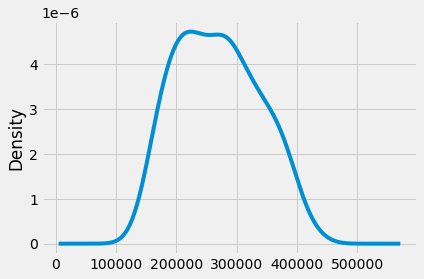

In [21]:
y.plot(kind='kde')

In [22]:
y

0      146737.0
1      147456.0
2      159729.0
3      164085.0
4      170497.0
         ...   
195    375400.0
196    405376.0
197    385737.0
198    391508.0
199    390393.0
Length: 200, dtype: float64

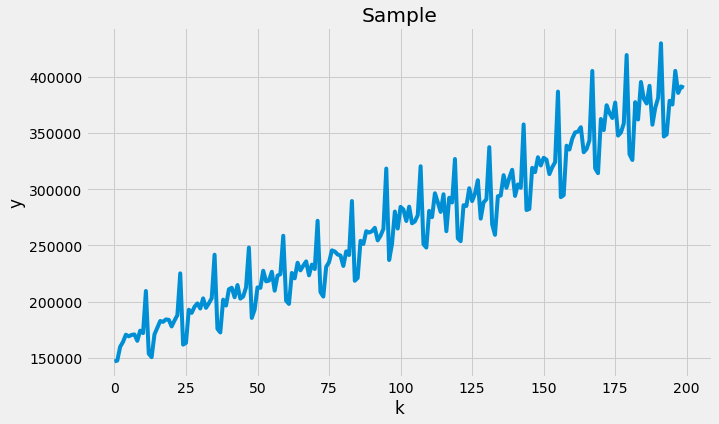

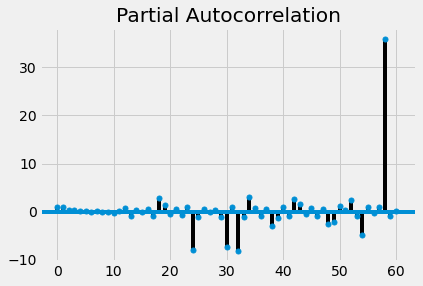

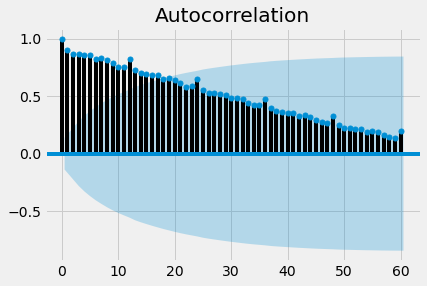

In [23]:
calculate_metrics_sample(y)
show_plots(y)

## Take log()

In [24]:
y_log = y
y = np.log(y)

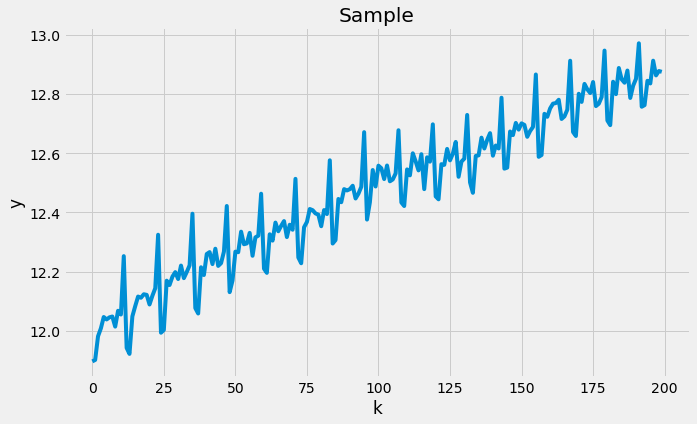

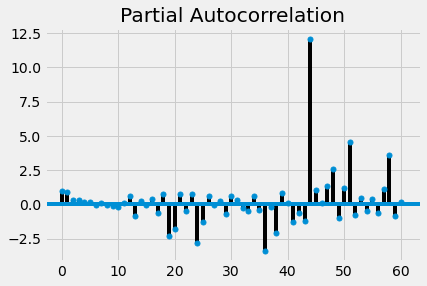

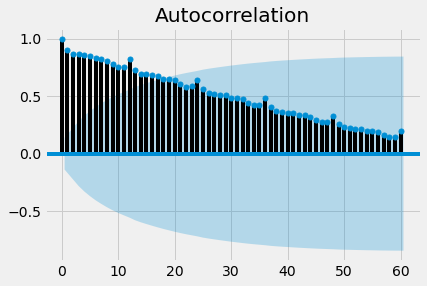

In [25]:
calculate_metrics_sample(y)
show_plots(y)

## побудова рівняння тренду

In [26]:
def prediction_arma(y, y_pred, res_val, p,q, thetta_ar, thetta_ma, intercept, period=1, pred_type='static'):
    
    y_real = y if pred_type=='static' else y_pred
    
    df_temp = pd.DataFrame(list(y_real), columns=['Value'])
    
    train_size = len(y_real) - period
    
    for i in range(1,p+1):
        df_temp[f'Shifted_values_{i}'] = df_temp['Value'].shift(i)
    
    
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])
    
    X_test_ar = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test_ar.dot(thetta_ar)
    
    # Work with residuals
    res = pd.DataFrame(list(res_val), columns=['Residuals'])
    for i in range(1,q+1):
         res[f'Shifted_values_{i}'] = res['Residuals'].shift(i)
       
    res_train_2 = res.dropna()
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    X_test_res = res_test.iloc[:,1:].values.reshape(-1,q)
    res_test['Predicted_Values'] = X_test_res.dot(theta_ma)
    
    
    prediction = pd.DataFrame(df_test['Predicted_Values'] + res_test['Predicted_Values'] + intercept,
                              columns=['Predicted_Values'])
    
    return prediction

In [27]:
# has not done
def prediction_trend(y, y_pred, trend, coef, intercep, period=1):
    time_y = np.array([i for i in range(len(y))])
    
    x = np.array([np.power(time_y, x) for x in range(1,trend + 1)])
    x = x.reshape((len(y), -1))
    
    

In [5]:
from sklearn.preprocessing import PolynomialFeatures

def trend_equal(y, trend=1):
    ser = pd.DataFrame(y)
    y_new = ser.values

    X = ser.index
    X = np.reshape(X, (len(X), 1))
    
    if trend != 1:
        pf = PolynomialFeatures(degree=trend)
        X = pf.fit_transform(X)

    
    model = LinearRegression()
    model.fit(X, y_new)
    pred = model.predict(X)
    
    return np.reshape(pred, (len(y),)), model.coef_, model.intercept_

In [29]:
def residuals(y ,y_pred):
    return np.array(y[len(y)-len(y_pred):] - np.array(y_pred))

def y_pred_to_trend(y_pred, y_trend):
    return np.array(y_trend[len(y_trend)-len(y_pred):] + np.array(y_pred))

In [30]:
file1 = open('ATS_Lab_04_new/data/RSAFSNA.txt')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])
# y = np.log(y)
# trend = 1
# y_trend_1, coef_trend_1, intercept_trend_1 = trend_equal(y, trend)
# show_prediction(y, y_trend_1, pred_title='trend_1')

In [31]:
models_metrics = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid','durbin_watson','params_ar','params_intercept'])
models_metrics_aprox = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid','durbin_watson','params_ar','params_intercept'])
predictions_model = []

trends = []

count = 5
for trend in range(1,count+1):

    y_trend_1, coef_trend_1, intercept_trend_1 = trend_equal(y, trend)
    metrics = claculate_metrics_trend(y, y_trend_1, trend=trend, params_ar=coef_trend_1, intercept=intercept_trend_1)
    trends.append(y_trend_1)
    models_metrics = models_metrics.append(metrics, ignore_index=True)
    predictions_model.append(y_trend_1)

models_metrics

True
True
True
True
True


,name,r_squared,sum_squared_resid,durbin_watson,params_ar,params_intercept
0,Trend(1),0.917203,7.67026e+10,2.07442,[[1128.9665116627916]],[156498.91208955226]
1,Trend(2),0.919794,7.4302e+10,2.14149,"[[0.0, 897.7067374017913, 1.162109418396858]]",[164130.48464016695]
2,Trend(3),0.920671,7.34895e+10,2.16505,"[[0.0, 1213.731081165306, -2.8180124583177886,...",[158955.530175747]
3,Trend(4),0.920705,7.3458e+10,2.16593,"[[0.0, 1330.1518044115646, -5.466062076451332,...",[157823.28626027395]
4,Trend(5),0.920794,7.33761e+10,2.16844,"[[0.0, 1022.4791232109754, 5.465242827428395, ...",[159792.65112558246]


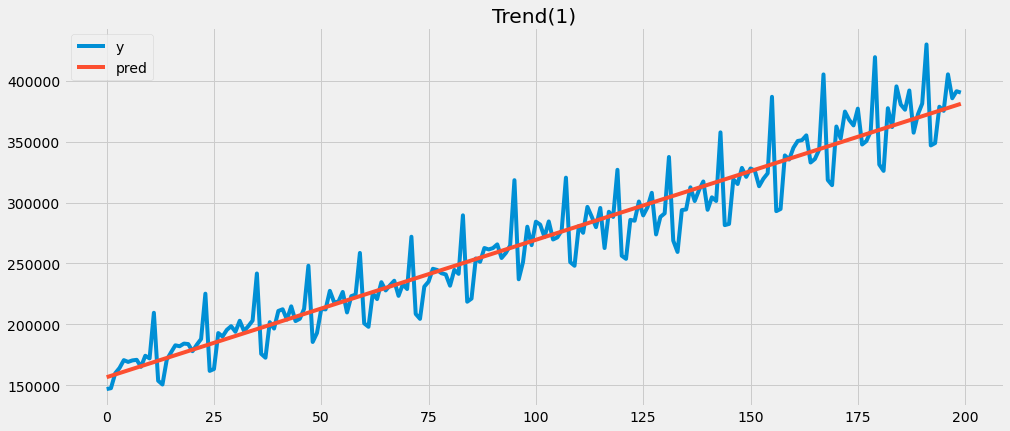

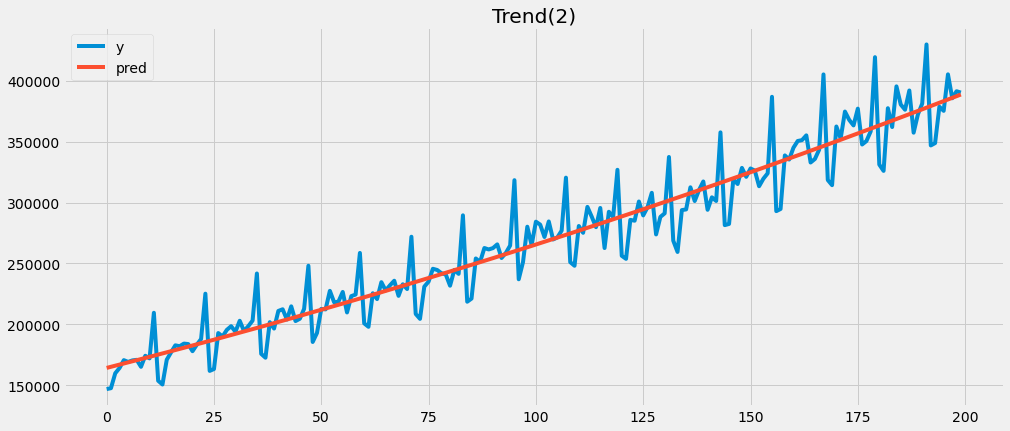

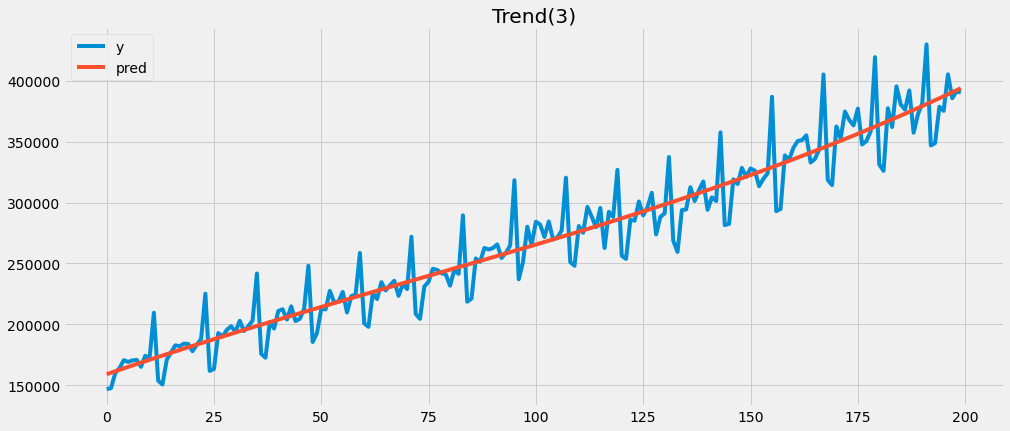

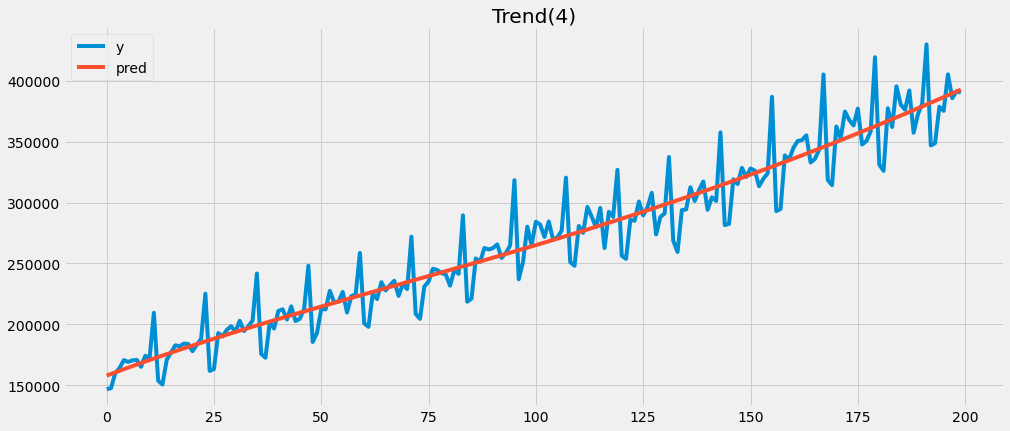

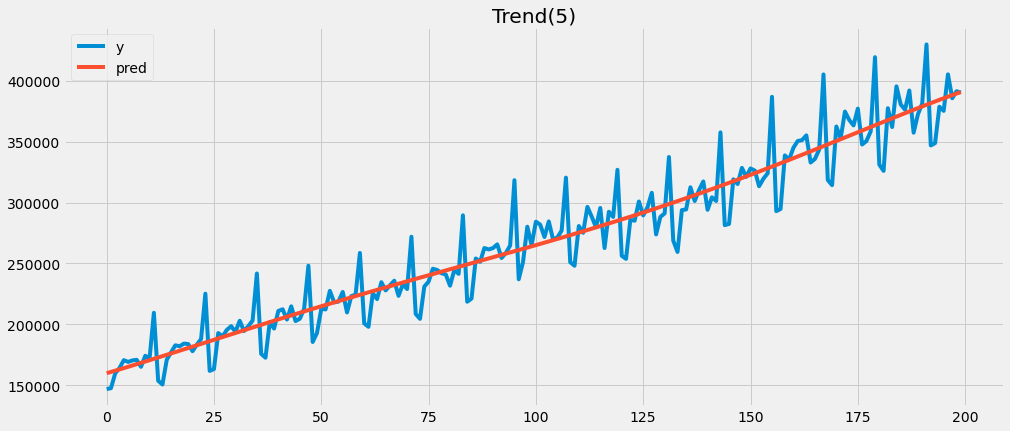

In [32]:
for name, y_pred in zip(models_metrics.name, predictions_model):
    show_prediction(y, y_pred, name)

In [34]:
trend_my = trends[2]
y_old = y.copy()

y_without_trend = y - trend_my
# trend_log = np.log(trend_my)
# y = np.log(y)

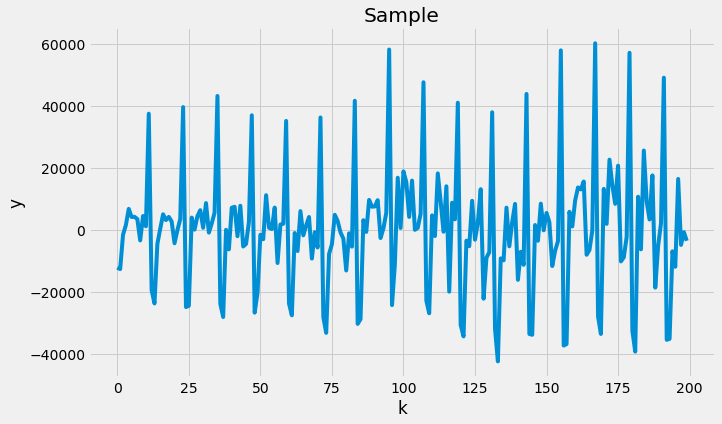

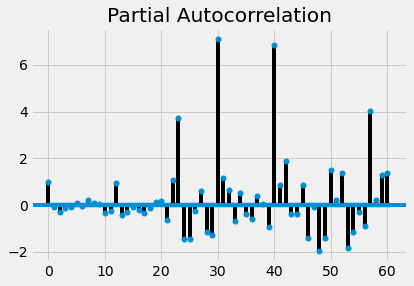

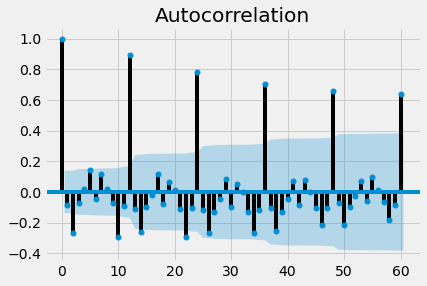

In [35]:
show_plots(y_without_trend)

In [37]:
model_ar = ARIMA(y_without_trend, (12,0,0))
model_ar_fit = model_ar.fit()

In [69]:
print(model_ar_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  200
Model:                    ARMA(12, 0)   Log Likelihood               -2052.989
Method:                       css-mle   S.D. of innovations         396592.311
Date:                Mon, 09 Nov 2020   AIC                           4133.977
Time:                        15:43:55   BIC                           4180.154
Sample:                             0   HQIC                          4152.664
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0768   2615.162  -2.94e-05      1.000   -5125.701    5125.547
ar.L1.y       -0.0040        nan        nan        nan         nan         nan
ar.L2.y        0.0178        nan        nan        n

In [59]:
predictions = model_ar.predict([x for x in range(0,200)]) + trend_my
values = y_without_trend + trend_my
claculate_metrics_Real(values, predictions, name, p=12,q=0, name='ARMA')

,name,r_squared,sum_squared_resid,durbin_watson
0,"Trend(5)(12, 0)",-5.4446558494837694e+19,5.043883282651178e+31,1.7834685709965117


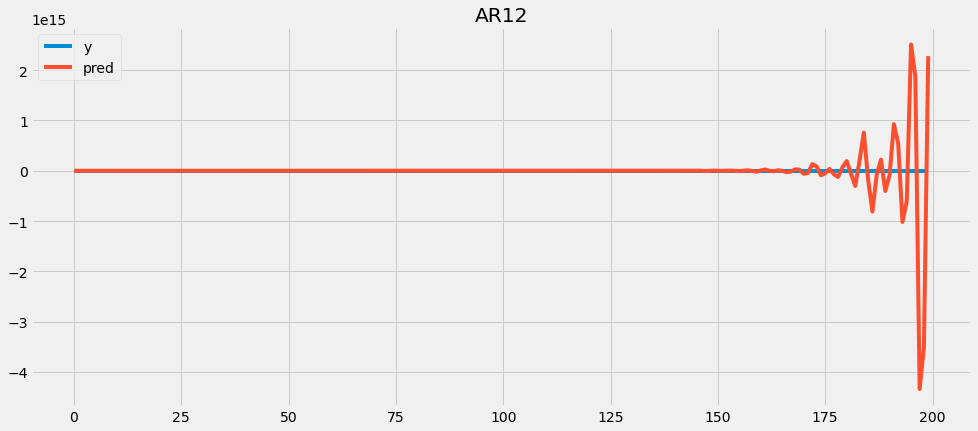

In [70]:
show_prediction(y_without_trend, model_ar.predict([x for x in range(0,200)]), f'AR{12}')

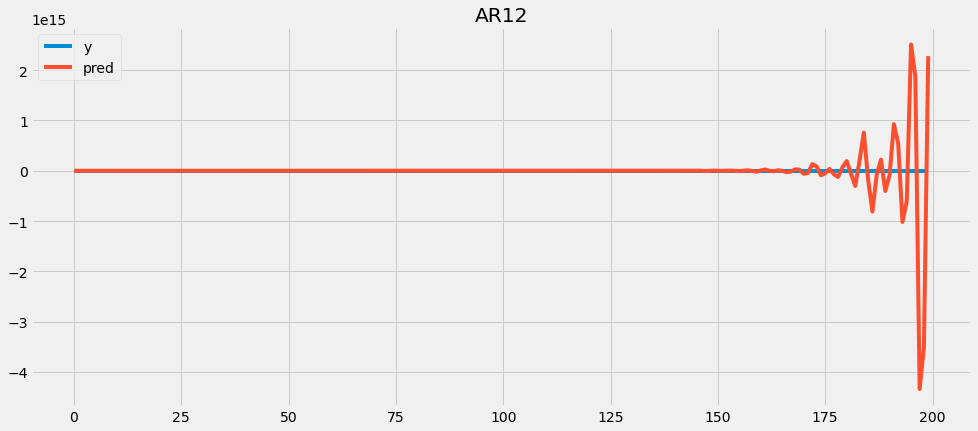

In [68]:
show_prediction(values, predictions, f'AR{12}')

# Step-by-step

In [26]:
def AR(p, y_):
    
    df_temp = pd.DataFrame(list(y_), columns=['Value'])
    
    for i in range(1,p+1):
        df_temp[f'Shifted_values_{i}'] = df_temp['Value'].shift(i)
    
    df_train_2 = df_temp.dropna()
#     df_train_2 = df_temp.fillna(0)
    X_train_ar = df_train_2.iloc[:,1:].values.reshape(-1,p)
    y_train_ar = df_train_2.iloc[:,0].values.reshape(-1,1)
    
    lr = LinearRegression()
    lr.fit(X_train_ar,y_train_ar)

    theta_ar  = lr.coef_.T
    intercept_ar = lr.intercept_

    df_train_2['Predicted_Values'] = X_train_ar.dot(theta_ar) + intercept_ar
    
    pred = list(df_train_2.Predicted_Values)
    

    return pred, theta_ar, intercept_ar

In [27]:
p = 12

prediction, theta_ar, intercept_ar = AR(p, y_without_trend)

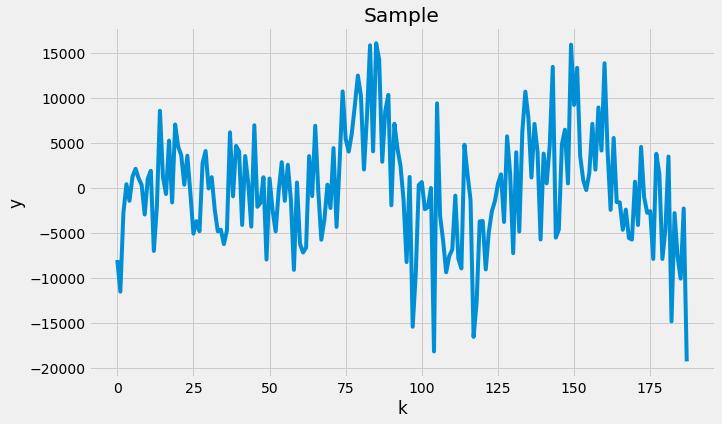

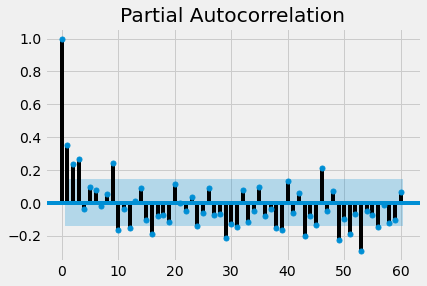

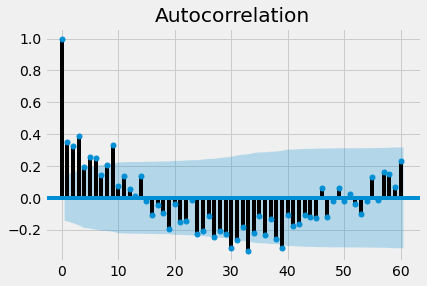

In [28]:
res =  residuals(y_without_trend, prediction)
show_plots(res)

In [30]:
claculate_metrics_model(y_without_trend, prediction, p, params_ar=theta_ar, intercept=intercept_ar)

False


,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((12, 0)) none:0",-8.45958,7.16475e+10,3738.61,1.98832,"[[-0.0029052295306409175], [0.0172663950702346...",empty,[-402.8262891095248]


In [31]:
claculate_metrics_model(y_old, y_pred_to_trend(prediction, trend_my), p, params_ar=theta_ar, intercept=intercept_ar)

False


,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((12, 0)) none:0",-1986.01,1.50498e+13,4743.92,0.00949184,"[[-0.0029052295306409175], [0.0172663950702346...",empty,[-402.8262891095248]


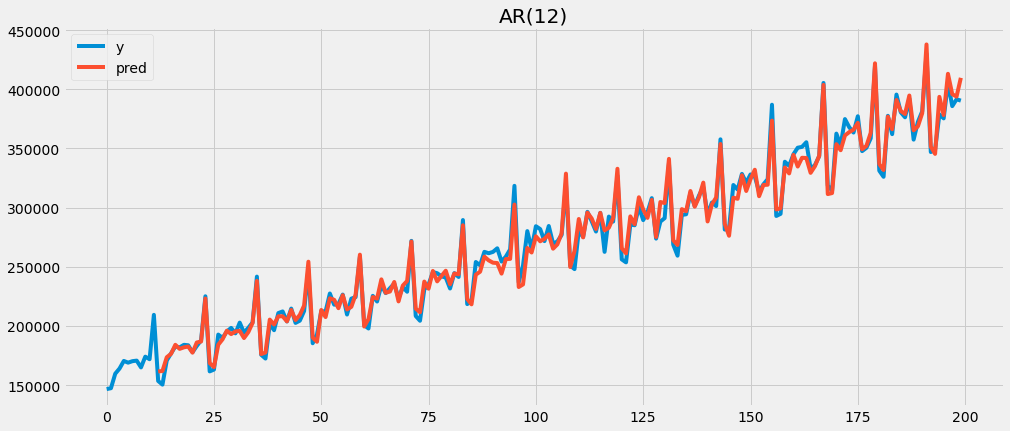

In [32]:
show_prediction(y_old, y_pred_to_trend(prediction, trend_my), name=f'AR({p})', pred_title='pred')

## ARMA model

In [33]:
def back_y_log(y):
    return np.exp(y)


In [34]:
def ARMA(p, q, y_, res_, b=None):
    
    df_temp = pd.DataFrame(list(y_), columns=['Value'])
    
    for i in range(1,p+1):
        df_temp[f'Shifted_values_{i}'] = df_temp['Value'].shift(i)
    
    df_train_2 = df_temp.dropna()
#     df_train_2 = df_temp.fillna(0)
    X_train_ar = df_train_2.iloc[:,1:].values.reshape(-1,p)
    y_train_ar = df_train_2.iloc[:,0].values.reshape(-1,1)
    
    lr = LinearRegression()
    lr.fit(X_train_ar,y_train_ar)

    theta_ar  = lr.coef_.T
    intercept_ar = lr.intercept_

    df_train_2['Predicted_Values'] = X_train_ar.dot(theta_ar) + intercept_ar
    
    #----------------
    res = pd.DataFrame(list(res_), columns=['Residuals'])
    for i in range(1,q+1):
         res[f'Shifted_values_{i}'] = res['Residuals'].shift(i)

    res_train_2 = res.dropna()
#     res_train_2 = res.fillna(0)
    X_train_ma = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train_ma = res_train_2.iloc[:,0].values.reshape(-1,1)
    
    if b is None:
        lr = LinearRegression()
        lr.fit(X_train_ma,y_train_ma)

        theta_ma  = lr.coef_.T
        intercept_ma = lr.intercept_
    else:
        theta_ma = np.array(b)
        intercept_ma = 0

    res_train_2['Predicted_Values'] = X_train_ma.dot(theta_ma) + intercept_ma

    prediction = pd.DataFrame(res_train_2['Predicted_Values'] + df_train_2['Predicted_Values'],columns=['Predicted_Values'])
#     pred = list(prediction['Predicted_Values'])
    prediction = prediction.dropna()
    pred = [x for x in y_[:max(p,q)]] + list(prediction.Predicted_Values)

    return pred,theta_ar, theta_ma, intercept_ar + intercept_ma

In [45]:
def get_y_without_res(y_, res_):
    return np.array(y_[len(y)-len(res):] - np.array(res_))

In [51]:
models_metrics_2 = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model_aprox_2 = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])

predictions_model_2 = []

p, q = 13, 9
y_without_res_ = get_y_without_res(y_without_trend, res)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_without_res_, res)
# y_real, y_aprox, pred = back_y_diff(y_old, y, pred)

# pred_real = np.exp(pred)
pred_real = y_pred_to_trend(pred, trend_my)

metrics = claculate_metrics_model(y_old, pred_real, p, q, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
metrics_aprox = claculate_metrics_model(y_without_trend, pred, p, q, params_ar=params_ar, params_ma=params_ma, intercept=intercept)

models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_aprox_2 = predictions_model_aprox_2.append(metrics_aprox, ignore_index=True)

predictions_model_2.append(pred_real)

False
False


In [52]:
models_metrics_2

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((13, 9)) none:0",-1881.26,1.50566e+13,4764,0.00949728,"[[0.3197125466578795], [-0.02379167763742712],...","[[0.19920262316867016], [0.16160601480407177],...",[-198.91533969427448]


In [53]:
predictions_model_aprox_2

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((13, 9)) none:0",-6.89429,6.31482e+10,3734.87,2.25833,"[[0.3197125466578795], [-0.02379167763742712],...","[[0.19920262316867016], [0.16160601480407177],...",[-198.91533969427448]


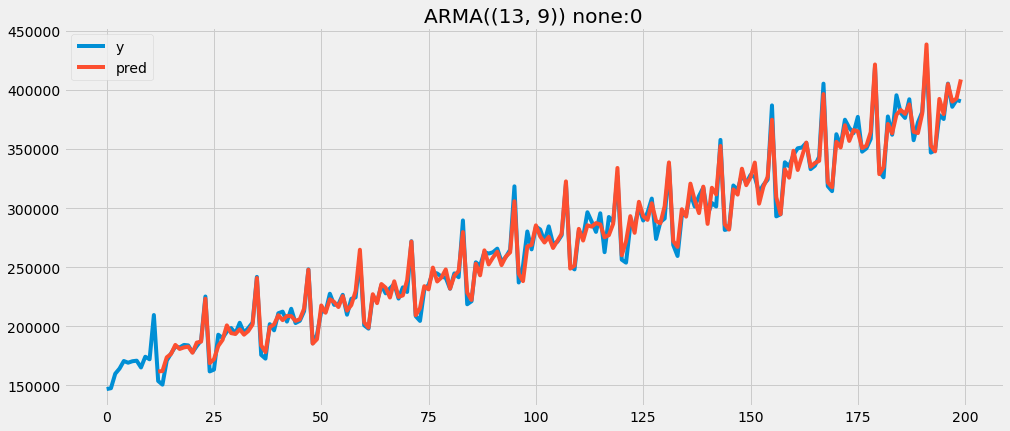

In [54]:
for name, y_pred in zip(models_metrics_2.name, predictions_model_2):
    show_prediction(y, y_pred, name)

## To stationary

In [2]:
def back_y_diff(y_old, y, pred, period=1):
    df = pd.DataFrame({'Value': y_old})
    df_c = pd.DataFrame({'Value': y, 'Predicted_Value': pred}).dropna()

    df_c.Value += np.log(df).Value
    df_c.Value += np.log(df).diff(period).Value
    df_c.Predicted_Value += np.log(df).Value
    df_c.Predicted_Value += np.log(df).diff(period).Value

    df_c = df_c.dropna()
    
    return y_old[len(y_old) - len(df_c.Value):], df_c.Value, df_c.Predicted_Value

{'series': 'Y', 'observations': 59, 'mode': -5.15275924931764, 'mean': 0.5710808881903299, 'median': 0.23847724078770405, 'variation': 3.754229191571159, 'skewness': -0.2261607293145285, 'kurtosis': 0.35284597831517495, 'jarque-bera': 0.6004932116608186, 'probability': 0.7406355531135936} 


Augmented Dickey-Fuller Test
ADF Test Statistic : -5.787863359228418
p-value : 4.950862105593016e-07
Number of Lags Used : 3
Number of Observations Used : 55
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary 4.950862105593016e-07
None


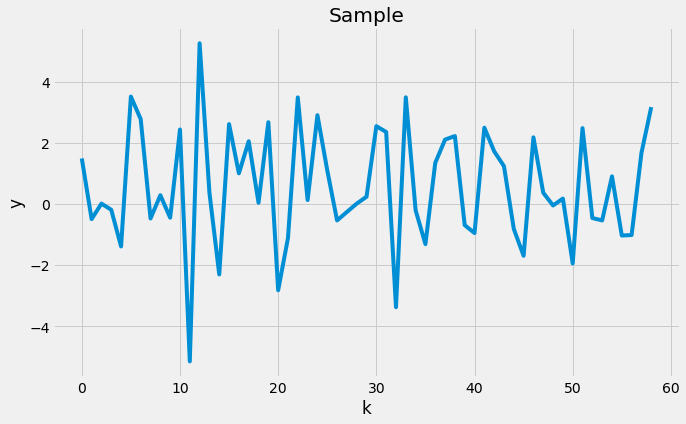

ValueError: operands could not be broadcast together with shapes (59,) (57,) (59,) 

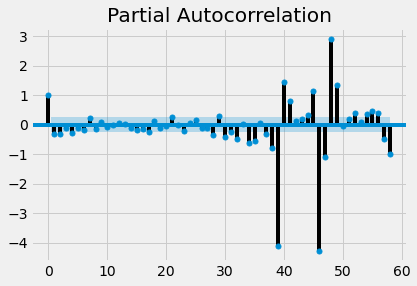

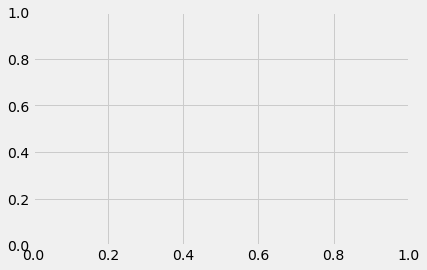

In [12]:
file1 = open('ATS_Lab_04_new/data/RSAFSNA.txt')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])

trend=3
y_trend_1, coef_trend_1, intercept_trend_1 = trend_equal(y, trend)

y_old = y.copy()
y_without_trend = y - y_trend_1
y = np.log(y_without_trend)

diff_y = pd.DataFrame(y).diff().dropna()


y = np.array(diff_y).reshape(1,-1)[0]
print(calculate_metrics_sample(y),'\n\n')
print(adf_check(y))
show_plots(y)

{'series': 'Y', 'observations': 199, 'mode': -0.3310560733662058, 'mean': 0.004917146006516334, 'median': 0.009279270407594353, 'variation': 0.010528197252768741, 'skewness': -1.1434481307722952, 'kurtosis': 2.224108872908513, 'jarque-bera': 80.635410384093, 'probability': 0.0} 


Augmented Dickey-Fuller Test
ADF Test Statistic : -2.994648506387489
p-value : 0.035397193767784725
Number of Lags Used : 13
Number of Observations Used : 185
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary 0.035397193767784725
None


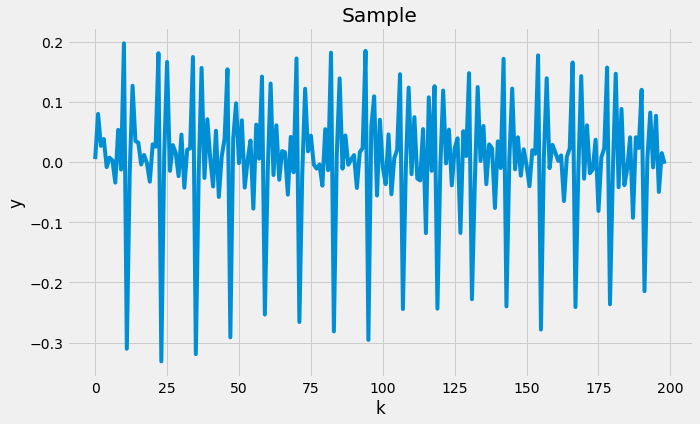

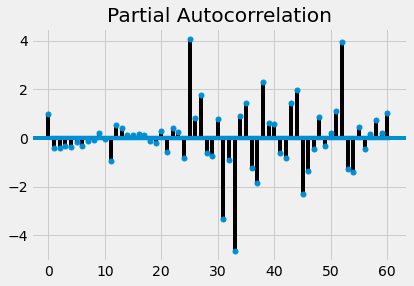

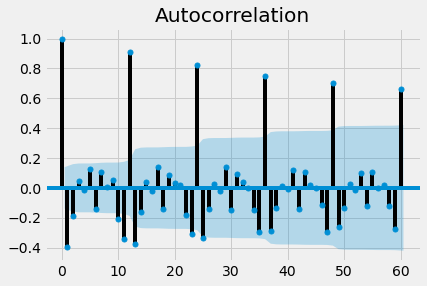

In [56]:
file1 = open('ATS_Lab_04_new/data/RSAFSNA.txt')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])



y_def = y
y = np.log(y)
y_old = y

diff_y = pd.DataFrame(y).diff().dropna()

y = np.array(diff_y).reshape(1,-1)[0]
print(calculate_metrics_sample(y),'\n\n')
print(adf_check(y))
show_plots(y)